INSPER - Big Data e Computação em Nuvem

# Big Data e Computação em Nuvem - Projeto Final: Análise de Atraso de Voos

**Integrantes**:
- Flávio
- Hélio
- Michel

In [44]:
#Importando as bibliotecas necessárias
import seaborn as sns
import pyspark.sql.functions as f
from pyspark.sql.types import StringType
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession, Row
from pyspark.sql.functions import col, sum, when, stddev, mean, count, isnan
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.stat import Correlation

In [45]:
# Criar a sessao do Spark

spark = SparkSession \
            .builder \
            .master("local[4]") \
            .appName("nyc_<mudar-nome>") \
            .config("spark.jars.packages", "org.apache.hadoop:hadoop-azure:3.3.4,com.microsoft.azure:azure-storage:8.6.6") \
            .getOrCreate()

In [46]:
STORAGE_ACCOUNT = 'dlspadseastusprod'
CONTAINER = 'big-data-comp-nuvem'
FOLDER = 'airline-delay'
TOKEN = 'lSuH4ZI9BhOFEhCF/7ZQbrpPBIhgtLcPDfXjJ8lMxQZjaADW4p6tcmiZGDX9u05o7FqSE2t9d2RD+ASt0YFG8g=='

spark.conf.set("fs.azure.account.key." + STORAGE_ACCOUNT + ".blob.core.windows.net", TOKEN)

In [47]:
# Vamos usar os dados de 2012
df = spark.read.csv("wasbs://{}@{}.blob.core.windows.net/{}/2012.csv".format(CONTAINER, STORAGE_ACCOUNT, FOLDER), header=True, inferSchema=True)

- Definir o escopo do negócio: qùal será a definição do atraso?
- A análise toda é do ponto do vista da empresa, consumidor ou governo (regulador)?
- Criar variavel resposta
- Tratamento de missing values
- Verificar a qualidade das informações (estao no tipo certo?)
- Criar colunas novas? Vamos manter todas as colunas para a etapa de modelagem?
- Vamos usar outras variaveis (preço de petroleo, pois QAV representa 41% do custo em 2022, segundo a ANAC)? Como era o desempenho economico em cada ano?
- Faremos filtros para retirar anos outliers?
- Vamos retirar outliers? Verificar anos atípicos
- verificar a influência de variáveis externa (desempenho economico, preço do petróleo, tempo)
- Matriz de correlação
- Analise bivariada: % atrasos por aeroporto, por regiao


### Definir o escopo do negócio: qùal será a definição do atraso?

O atraso será definido a partir da soma das coluna DEP_DELAY e ARR_DELAY. Sem tolerência de atraso (DEP_DELAY + ARR_DELAY > 0).

In [48]:
df.printSchema()

root
 |-- FL_DATE: timestamp (nullable = true)
 |-- OP_CARRIER: string (nullable = true)
 |-- OP_CARRIER_FL_NUM: integer (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- CRS_DEP_TIME: double (nullable = true)
 |-- DEP_TIME: double (nullable = true)
 |-- DEP_DELAY: double (nullable = true)
 |-- TAXI_OUT: double (nullable = true)
 |-- WHEELS_OFF: double (nullable = true)
 |-- WHEELS_ON: double (nullable = true)
 |-- TAXI_IN: double (nullable = true)
 |-- CRS_ARR_TIME: double (nullable = true)
 |-- ARR_TIME: double (nullable = true)
 |-- ARR_DELAY: double (nullable = true)
 |-- CANCELLED: double (nullable = true)
 |-- CANCELLATION_CODE: string (nullable = true)
 |-- DIVERTED: double (nullable = true)
 |-- CRS_ELAPSED_TIME: double (nullable = true)
 |-- ACTUAL_ELAPSED_TIME: double (nullable = true)
 |-- AIR_TIME: double (nullable = true)
 |-- DISTANCE: double (nullable = true)
 |-- CARRIER_DELAY: double (nullable = true)
 |-- WEATHER_DELAY: d

In [49]:
df.limit(5).toPandas()

/opt/conda/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


,FL_DATE,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,...,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Unnamed: 27
0,2012-01-01,MQ,4041,BMI,ORD,1715.0,1702.0,-13.0,9.0,1711.0,...,55.0,55.0,37.0,116.0,NaN,NaN,NaN,NaN,NaN,None
1,2012-01-01,MQ,4041,ORD,BMI,1545.0,1540.0,-5.0,11.0,1551.0,...,50.0,39.0,23.0,116.0,NaN,NaN,NaN,NaN,NaN,None
2,2012-01-01,MQ,4042,SGF,ORD,715.0,705.0,-10.0,12.0,717.0,...,115.0,105.0,75.0,438.0,NaN,NaN,NaN,NaN,NaN,None
3,2012-01-01,MQ,4045,ORD,DBQ,1535.0,1529.0,-6.0,13.0,1542.0,...,55.0,46.0,31.0,147.0,NaN,NaN,NaN,NaN,NaN,None
4,2012-01-01,MQ,4047,ORD,RIC,1600.0,1615.0,15.0,12.0,1627.0,...,115.0,109.0,86.0,642.0,NaN,NaN,NaN,NaN,NaN,None


In [50]:
#Remover a coluna Unnamed
df = df.drop("Unnamed: 27")
df.limit(5).toPandas()

/opt/conda/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


,FL_DATE,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,...,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
0,2012-01-01,MQ,4041,BMI,ORD,1715.0,1702.0,-13.0,9.0,1711.0,...,0.0,55.0,55.0,37.0,116.0,NaN,NaN,NaN,NaN,NaN
1,2012-01-01,MQ,4041,ORD,BMI,1545.0,1540.0,-5.0,11.0,1551.0,...,0.0,50.0,39.0,23.0,116.0,NaN,NaN,NaN,NaN,NaN
2,2012-01-01,MQ,4042,SGF,ORD,715.0,705.0,-10.0,12.0,717.0,...,0.0,115.0,105.0,75.0,438.0,NaN,NaN,NaN,NaN,NaN
3,2012-01-01,MQ,4045,ORD,DBQ,1535.0,1529.0,-6.0,13.0,1542.0,...,0.0,55.0,46.0,31.0,147.0,NaN,NaN,NaN,NaN,NaN
4,2012-01-01,MQ,4047,ORD,RIC,1600.0,1615.0,15.0,12.0,1627.0,...,0.0,115.0,109.0,86.0,642.0,NaN,NaN,NaN,NaN,NaN


In [51]:
# numero de linhas
total_rows = df.count()
total_rows

6096762

# Feature Engineering

### Criar novas colunas


In [52]:
#Criar a variável reposta a partir da soma das colunas ARR_DELAY DEP_DELAY
df = df.withColumn("DELAY", 
                   when(df['ARR_DELAY'] +  df['DEP_DELAY'] > 0, 1)
                   .otherwise(0))

In [53]:
# Criar uma variável com o mês do voo
df = df.withColumn('FL_MONTH', f.month(df.FL_DATE))

In [54]:
# Criar uma variável o período que o voo saiu (manha, tarde, noite, madrugada)
df = df.withColumn("DEP_PERIOD", 
                   when((df['DEP_TIME'] >= 0) & (df['DEP_TIME'] < 600), "Madrugada")
                   .when((df['DEP_TIME'] >= 600) & (df['DEP_TIME'] < 1200), "Manha")
                   .when((df['DEP_TIME'] >= 1200) & (df['DEP_TIME'] < 1800), "Tarde")
                   .when((df['DEP_TIME'] >= 1800) & (df['DEP_TIME'] <= 2400), "Noite")
                   .otherwise("Nao Identificado"))

In [55]:
# Criar uma variável o período que o voo chegou (manha, tarde, noite, madrugada)
df = df.withColumn("ARR_PERIOD", 
                   when((df['ARR_TIME'] >= 0) & (df['ARR_TIME'] < 600), "Madrugada")
                   .when((df['ARR_TIME'] >= 600) & (df['ARR_TIME'] < 1200), "Manha")
                   .when((df['ARR_TIME'] >= 1200) & (df['ARR_TIME'] < 1800), "Tarde")
                   .when((df['ARR_TIME'] >= 1800) & (df['ARR_TIME'] <= 2400), "Noite")
                   .otherwise("Nao Identificado"))

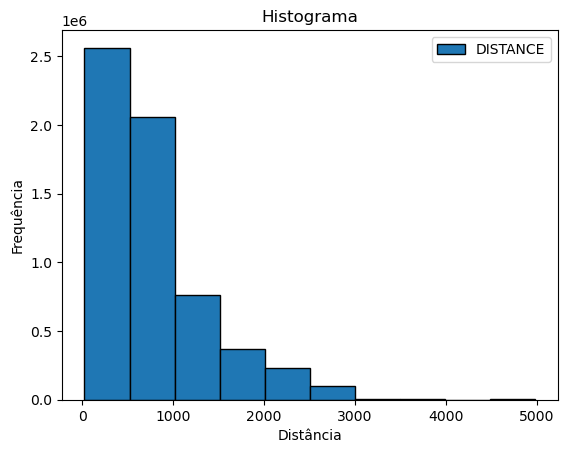

In [56]:
# Cria um dataframe com os dados da coluna DISTANCE
df_distance = df.select(df['DISTANCE']).toPandas()

# Plota histograma das distâncias com 10 bins para verificar a distribuição dos voos
df_distance.plot.hist(bins=10, edgecolor='black')
plt.title('Histograma')
plt.xlabel('Distância')
plt.ylabel('Frequência')
plt.show()

A partir do histograma acima, vamos definir o seguinte critério para classificar as distâncias:

- próximo: abaixo de 500 milhas
- médio: entre 500 e 1000 milhas
- distante: acima de 1000 milhas

In [57]:
#Criar coluna "Tipo de Distância" com o critério acima
df = df.withColumn("DISTANCE_TYPE", 
                   when(df['DISTANCE'] > 1000, "distant")
                   .when(df['DISTANCE'] > 500, "medium")
                   .otherwise("near"))

### Filtrar os voos cancelados

Filtrar os voos cancelados, uma vez que não há atraso em relação a eles.

In [58]:
df = df.filter(df['CANCELLED'] == 0)

### Análise do Tipo de Dado de algumas colunas

Como no dicionário de dados não está claro o tipo de informação contida em algumas colunas, vamos fazer essa análise abaixo:

In [59]:
df.select('DIVERTED').describe().toPandas()

,summary,DIVERTED
0,count,6017900
1,mean,0.002080293790192592
2,stddev,0.045562775518007345
3,min,0.0
4,max,1.0


In [60]:
df.select('CARRIER_DELAY').describe().toPandas()

,summary,CARRIER_DELAY
0,count,1015158
1,mean,17.89421548172797
2,stddev,45.56229030399185
3,min,0.0
4,max,1823.0


In [61]:
df.select('WEATHER_DELAY').describe().toPandas()

,summary,WEATHER_DELAY
0,count,1015158
1,mean,2.2457686389704854
2,stddev,17.272722643396154
3,min,0.0
4,max,1615.0


In [62]:
df.select('NAS_DELAY').describe().toPandas()

,summary,NAS_DELAY
0,count,1015158
1,mean,12.637266317164421
2,stddev,25.90985229314727
3,min,0.0
4,max,1207.0


In [63]:
df.select('SECURITY_DELAY').describe().toPandas()

,summary,SECURITY_DELAY
0,count,1015158
1,mean,0.07196121194927292
2,stddev,2.110994781167227
3,min,0.0
4,max,717.0


In [64]:
df.select('LATE_AIRCRAFT_DELAY').describe().toPandas()

,summary,LATE_AIRCRAFT_DELAY
0,count,1015158
1,mean,23.217619326252663
2,stddev,41.40641306888853
3,min,0.0
4,max,1201.0


In [65]:
df.select('CANCELLATION_CODE').describe().toPandas()

,summary,CANCELLATION_CODE
0,count,0
1,mean,None
2,stddev,None
3,min,None
4,max,None


- DIVERTED é uma variável 0 e 1.
- A colunas de cancelamento são em minutos.
- A coluna CANCELLATION_CODE não possui valores. Logo, vamos excluí-la.

### Remover as colunas que não serão utilizadas

 - FL_DATE: coluna de data. Será excluída, pois vamos usar a coluna MONTH para verificar alguma sazonalidade
 - OP_CARRIER_FL_NUM: ID do voo
 - CRS_DEP_TIME, DEP_TIME, DEP_DELAY, WHEELS_OFF, ARR_TIME, ARR_DELAY, WHEELS_ON e CRS_ARR_TIME: informação do horário planejado do voo. Esta informação já está no DELAY
 - CANCELLED: foram filtrados os valores, restando apenas ZERO nessa coluna
 - CANCELLATION_CODE: não possui valores

In [66]:
#Removendo colunas que não serão utilizadas
df = df.drop('FL_DATE', 'CRS_DEP_TIME', 'DEP_TIME', 'WHEELS_OFF', 'WHEELS_ON',
                   'CRS_ARR_TIME', 'ARR_TIME', 'OP_CARRIER_FL_NUM', 'ARR_DELAY', 
                  'DEP_DELAY', 'CANCELLED', 'CANCELLATION_CODE')

### Análise dos Missing Values

In [67]:
# Colocar em cache, pois os códigos de contagem são lentos
df.cache()

DataFrame[OP_CARRIER: string, ORIGIN: string, DEST: string, TAXI_OUT: double, TAXI_IN: double, DIVERTED: double, CRS_ELAPSED_TIME: double, ACTUAL_ELAPSED_TIME: double, AIR_TIME: double, DISTANCE: double, CARRIER_DELAY: double, WEATHER_DELAY: double, NAS_DELAY: double, SECURITY_DELAY: double, LATE_AIRCRAFT_DELAY: double, DELAY: int, FL_MONTH: int, DEP_PERIOD: string, ARR_PERIOD: string, DISTANCE_TYPE: string]

In [68]:
#Verificando os missing values
{col:df.filter(df[col].isNull()).count() for col in df.columns}

{'OP_CARRIER': 0,
 'ORIGIN': 0,
 'DEST': 0,
 'TAXI_OUT': 0,
 'TAXI_IN': 2032,
 'DIVERTED': 0,
 'CRS_ELAPSED_TIME': 1,
 'ACTUAL_ELAPSED_TIME': 12519,
 'AIR_TIME': 12519,
 'DISTANCE': 0,
 'CARRIER_DELAY': 5002742,
 'WEATHER_DELAY': 5002742,
 'NAS_DELAY': 5002742,
 'SECURITY_DELAY': 5002742,
 'LATE_AIRCRAFT_DELAY': 5002742,
 'DELAY': 0,
 'FL_MONTH': 0,
 'DEP_PERIOD': 0,
 'ARR_PERIOD': 0,
 'DISTANCE_TYPE': 0}

Preencher os missing values das colunas abaixo com ZERO:

- CARRIER_DELAY
- WEATHER_DELAY
- NAS_DELAY
- SECURITY_DELAY
- LATE_AIRCRAFT_DELAY

In [69]:
df = df.na.fill(0, subset=["CARRIER_DELAY", "WEATHER_DELAY", "NAS_DELAY", "SECURITY_DELAY", "LATE_AIRCRAFT_DELAY"])

In [70]:
#tratar os missing values (inicialmente coloquei para excluir todas as linhas que tem missing values, pois representam menos de 1% )
df = df.na.drop(subset=['DELAY', 'CRS_ELAPSED_TIME', 'AIR_TIME', 'ACTUAL_ELAPSED_TIME'])

In [71]:
#Verificando se as linhas com missing values foram excluiídas
{col:df.filter(df[col].isNull()).count() for col in df.columns}

{'OP_CARRIER': 0,
 'ORIGIN': 0,
 'DEST': 0,
 'TAXI_OUT': 0,
 'TAXI_IN': 0,
 'DIVERTED': 0,
 'CRS_ELAPSED_TIME': 0,
 'ACTUAL_ELAPSED_TIME': 0,
 'AIR_TIME': 0,
 'DISTANCE': 0,
 'CARRIER_DELAY': 0,
 'WEATHER_DELAY': 0,
 'NAS_DELAY': 0,
 'SECURITY_DELAY': 0,
 'LATE_AIRCRAFT_DELAY': 0,
 'DELAY': 0,
 'FL_MONTH': 0,
 'DEP_PERIOD': 0,
 'ARR_PERIOD': 0,
 'DISTANCE_TYPE': 0}

### Análise da Qualidade das Informações

In [73]:
# Verificar se há valores negativos
def conta_negativo(coluna):
    try: 
        return df.filter((df[coluna]<0)).count()
    except:
        return "Variável não numérica"

{col:conta_negativo(col) for col in df.columns}

{'OP_CARRIER': 0,
 'ORIGIN': 0,
 'DEST': 0,
 'TAXI_OUT': 0,
 'TAXI_IN': 0,
 'DIVERTED': 0,
 'CRS_ELAPSED_TIME': 0,
 'ACTUAL_ELAPSED_TIME': 0,
 'AIR_TIME': 0,
 'DISTANCE': 0,
 'CARRIER_DELAY': 0,
 'WEATHER_DELAY': 0,
 'NAS_DELAY': 0,
 'SECURITY_DELAY': 0,
 'LATE_AIRCRAFT_DELAY': 0,
 'DELAY': 0,
 'FL_MONTH': 0,
 'DEP_PERIOD': 0,
 'ARR_PERIOD': 0,
 'DISTANCE_TYPE': 0}

### Análise Exploratória

In [72]:
#exibir as principais estatísticas descritivas do conjunto de dados.
df.describe().show()

+-------+----------+-------+-------+------------------+-----------------+--------+------------------+-------------------+------------------+-----------------+-----------------+------------------+------------------+-------------------+-------------------+------------------+-----------------+----------+----------+-------------+
|summary|OP_CARRIER| ORIGIN|   DEST|          TAXI_OUT|          TAXI_IN|DIVERTED|  CRS_ELAPSED_TIME|ACTUAL_ELAPSED_TIME|          AIR_TIME|         DISTANCE|    CARRIER_DELAY|     WEATHER_DELAY|         NAS_DELAY|     SECURITY_DELAY|LATE_AIRCRAFT_DELAY|             DELAY|         FL_MONTH|DEP_PERIOD|ARR_PERIOD|DISTANCE_TYPE|
+-------+----------+-------+-------+------------------+-----------------+--------+------------------+-------------------+------------------+-----------------+-----------------+------------------+------------------+-------------------+-------------------+------------------+-----------------+----------+----------+-------------+
|  count|   6005

In [97]:
df.printSchema()

root
 |-- OP_CARRIER: string (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- TAXI_OUT: double (nullable = true)
 |-- TAXI_IN: double (nullable = true)
 |-- DIVERTED: double (nullable = true)
 |-- CRS_ELAPSED_TIME: double (nullable = true)
 |-- ACTUAL_ELAPSED_TIME: double (nullable = true)
 |-- AIR_TIME: double (nullable = true)
 |-- DISTANCE: double (nullable = true)
 |-- CARRIER_DELAY: double (nullable = false)
 |-- WEATHER_DELAY: double (nullable = false)
 |-- NAS_DELAY: double (nullable = false)
 |-- SECURITY_DELAY: double (nullable = false)
 |-- LATE_AIRCRAFT_DELAY: double (nullable = false)
 |-- DELAY: integer (nullable = false)
 |-- FL_MONTH: integer (nullable = true)
 |-- DEP_PERIOD: string (nullable = false)
 |-- ARR_PERIOD: string (nullable = false)
 |-- DISTANCE_TYPE: string (nullable = false)



# Analise bivariada: % atrasos por aeroporto, por regiao etc.

### Matriz de Correlação

In [77]:
# verificar quais são as colunas numéricas
colunas_numericas = [coluna for coluna, tipo in df.dtypes if tipo in ['int', 'double']]
# Selecionar apenas colunas numéricas
df_numericas = df.select(*colunas_numericas)
df_numericas.printSchema()

root
 |-- TAXI_OUT: double (nullable = true)
 |-- TAXI_IN: double (nullable = true)
 |-- DIVERTED: double (nullable = true)
 |-- CRS_ELAPSED_TIME: double (nullable = true)
 |-- ACTUAL_ELAPSED_TIME: double (nullable = true)
 |-- AIR_TIME: double (nullable = true)
 |-- DISTANCE: double (nullable = true)
 |-- CARRIER_DELAY: double (nullable = false)
 |-- WEATHER_DELAY: double (nullable = false)
 |-- NAS_DELAY: double (nullable = false)
 |-- SECURITY_DELAY: double (nullable = false)
 |-- LATE_AIRCRAFT_DELAY: double (nullable = false)
 |-- DELAY: integer (nullable = false)
 |-- FL_MONTH: integer (nullable = true)



<AxesSubplot: >

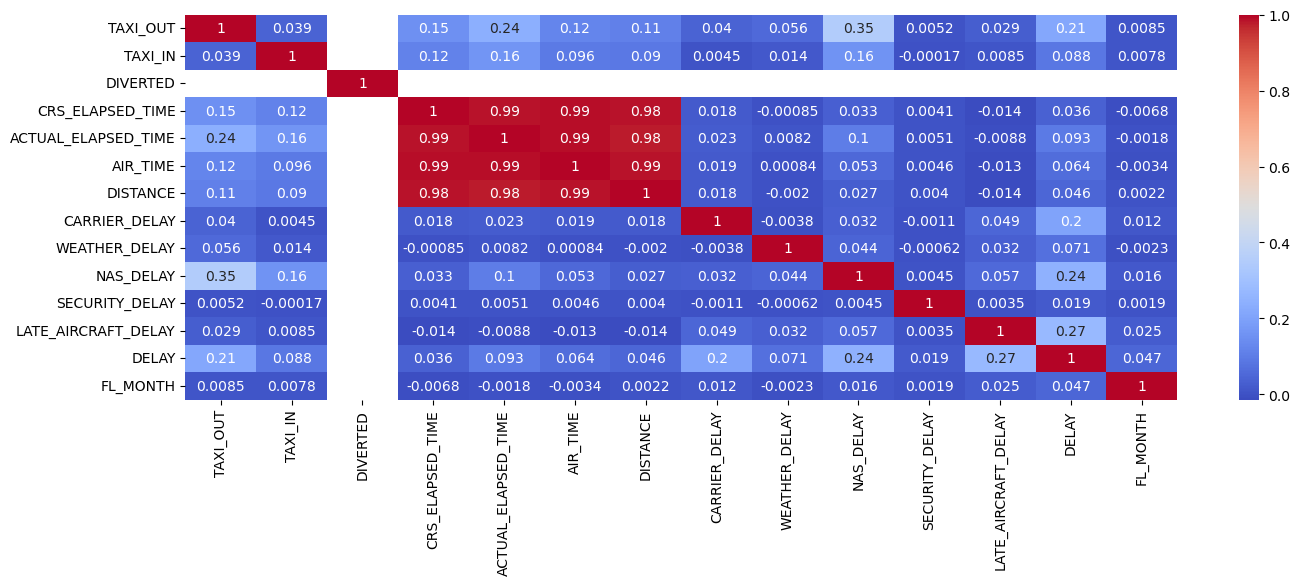

In [90]:
# converter para um coluna vetor 
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=df_numericas.columns, outputCol=vector_col)
df_vector = assembler.transform(df_numericas).select(vector_col)

# Obter a matriz de correlação
matrix = Correlation.corr(df_vector, vector_col).collect()[0][0].toArray()
corr_matrix = matrix.tolist() 

# Colocar as correlações das variáveis num dataframe em pandas
corr_matrix_df = pd.DataFrame(data=corr_matrix, columns = df_numericas.columns, index=df_numericas.columns)

# Plotar a matriz
plt.figure(figsize=(16,5))  
sns.heatmap(corr_matrix_df, 
            xticklabels=corr_matrix_df.columns.values,
            yticklabels=corr_matrix_df.columns.values,  cmap="coolwarm", annot=True)

In [91]:

#Verificar outliers
# Calcule a média e o desvio padrão
mean_value = df_numericas.agg(mean("value").alias("mean")).collect()[0]["mean"]
stddev_value = df_numericas.agg(stddev("value").alias("stddev")).collect()[0]["stddev"]

# Defina um limite para identificar outliers (por exemplo, 3 desvios padrão da média)
lower_limit = mean_value - 3 * stddev_value
upper_limit = mean_value + 3 * stddev_value

# Identifique outliers
outliers = df_numericas.filter((col("value") < lower_limit) | (col("value") > upper_limit))

# Contagem de outliers
num_outliers = outliers.count()

# Mostra o resultado
print(f"Número de outliers: {num_outliers}")
outliers.show()

AnalysisException: Column 'value' does not exist. Did you mean one of the following? [DELAY, TAXI_IN, AIR_TIME, DISTANCE, DIVERTED, FL_MONTH, TAXI_OUT, NAS_DELAY, CARRIER_DELAY, WEATHER_DELAY, SECURITY_DELAY, CRS_ELAPSED_TIME, ACTUAL_ELAPSED_TIME, LATE_AIRCRAFT_DELAY];
'Aggregate [avg('value) AS mean#45185]
+- Project [TAXI_OUT#8226, TAXI_IN#8229, DIVERTED#8235, CRS_ELAPSED_TIME#8236, ACTUAL_ELAPSED_TIME#8237, AIR_TIME#8238, DISTANCE#8239, CARRIER_DELAY#18645, WEATHER_DELAY#18646, NAS_DELAY#18647, SECURITY_DELAY#18648, LATE_AIRCRAFT_DELAY#18649, DELAY#8389, FL_MONTH#8418]
   +- Filter atleastnnonnulls(4, DELAY#8389, CRS_ELAPSED_TIME#8236, AIR_TIME#8238, ACTUAL_ELAPSED_TIME#8237)
      +- Project [OP_CARRIER#8219, ORIGIN#8221, DEST#8222, TAXI_OUT#8226, TAXI_IN#8229, DIVERTED#8235, CRS_ELAPSED_TIME#8236, ACTUAL_ELAPSED_TIME#8237, AIR_TIME#8238, DISTANCE#8239, coalesce(nanvl(CARRIER_DELAY#8240, cast(null as double)), cast(0.0 as double)) AS CARRIER_DELAY#18645, coalesce(nanvl(WEATHER_DELAY#8241, cast(null as double)), cast(0.0 as double)) AS WEATHER_DELAY#18646, coalesce(nanvl(NAS_DELAY#8242, cast(null as double)), cast(0.0 as double)) AS NAS_DELAY#18647, coalesce(nanvl(SECURITY_DELAY#8243, cast(null as double)), cast(0.0 as double)) AS SECURITY_DELAY#18648, coalesce(nanvl(LATE_AIRCRAFT_DELAY#8244, cast(null as double)), cast(0.0 as double)) AS LATE_AIRCRAFT_DELAY#18649, DELAY#8389, FL_MONTH#8418, DEP_PERIOD#8448, ARR_PERIOD#8479, DISTANCE_TYPE#8513]
         +- Project [OP_CARRIER#8219, ORIGIN#8221, DEST#8222, TAXI_OUT#8226, TAXI_IN#8229, DIVERTED#8235, CRS_ELAPSED_TIME#8236, ACTUAL_ELAPSED_TIME#8237, AIR_TIME#8238, DISTANCE#8239, CARRIER_DELAY#8240, WEATHER_DELAY#8241, NAS_DELAY#8242, SECURITY_DELAY#8243, LATE_AIRCRAFT_DELAY#8244, DELAY#8389, FL_MONTH#8418, DEP_PERIOD#8448, ARR_PERIOD#8479, DISTANCE_TYPE#8513]
            +- Filter (CANCELLED#8233 = cast(0 as double))
               +- Project [FL_DATE#8218, OP_CARRIER#8219, OP_CARRIER_FL_NUM#8220, ORIGIN#8221, DEST#8222, CRS_DEP_TIME#8223, DEP_TIME#8224, DEP_DELAY#8225, TAXI_OUT#8226, WHEELS_OFF#8227, WHEELS_ON#8228, TAXI_IN#8229, CRS_ARR_TIME#8230, ARR_TIME#8231, ARR_DELAY#8232, CANCELLED#8233, CANCELLATION_CODE#8234, DIVERTED#8235, CRS_ELAPSED_TIME#8236, ACTUAL_ELAPSED_TIME#8237, AIR_TIME#8238, DISTANCE#8239, CARRIER_DELAY#8240, WEATHER_DELAY#8241, ... 8 more fields]
                  +- Project [FL_DATE#8218, OP_CARRIER#8219, OP_CARRIER_FL_NUM#8220, ORIGIN#8221, DEST#8222, CRS_DEP_TIME#8223, DEP_TIME#8224, DEP_DELAY#8225, TAXI_OUT#8226, WHEELS_OFF#8227, WHEELS_ON#8228, TAXI_IN#8229, CRS_ARR_TIME#8230, ARR_TIME#8231, ARR_DELAY#8232, CANCELLED#8233, CANCELLATION_CODE#8234, DIVERTED#8235, CRS_ELAPSED_TIME#8236, ACTUAL_ELAPSED_TIME#8237, AIR_TIME#8238, DISTANCE#8239, CARRIER_DELAY#8240, WEATHER_DELAY#8241, ... 7 more fields]
                     +- Project [FL_DATE#8218, OP_CARRIER#8219, OP_CARRIER_FL_NUM#8220, ORIGIN#8221, DEST#8222, CRS_DEP_TIME#8223, DEP_TIME#8224, DEP_DELAY#8225, TAXI_OUT#8226, WHEELS_OFF#8227, WHEELS_ON#8228, TAXI_IN#8229, CRS_ARR_TIME#8230, ARR_TIME#8231, ARR_DELAY#8232, CANCELLED#8233, CANCELLATION_CODE#8234, DIVERTED#8235, CRS_ELAPSED_TIME#8236, ACTUAL_ELAPSED_TIME#8237, AIR_TIME#8238, DISTANCE#8239, CARRIER_DELAY#8240, WEATHER_DELAY#8241, ... 6 more fields]
                        +- Project [FL_DATE#8218, OP_CARRIER#8219, OP_CARRIER_FL_NUM#8220, ORIGIN#8221, DEST#8222, CRS_DEP_TIME#8223, DEP_TIME#8224, DEP_DELAY#8225, TAXI_OUT#8226, WHEELS_OFF#8227, WHEELS_ON#8228, TAXI_IN#8229, CRS_ARR_TIME#8230, ARR_TIME#8231, ARR_DELAY#8232, CANCELLED#8233, CANCELLATION_CODE#8234, DIVERTED#8235, CRS_ELAPSED_TIME#8236, ACTUAL_ELAPSED_TIME#8237, AIR_TIME#8238, DISTANCE#8239, CARRIER_DELAY#8240, WEATHER_DELAY#8241, ... 5 more fields]
                           +- Project [FL_DATE#8218, OP_CARRIER#8219, OP_CARRIER_FL_NUM#8220, ORIGIN#8221, DEST#8222, CRS_DEP_TIME#8223, DEP_TIME#8224, DEP_DELAY#8225, TAXI_OUT#8226, WHEELS_OFF#8227, WHEELS_ON#8228, TAXI_IN#8229, CRS_ARR_TIME#8230, ARR_TIME#8231, ARR_DELAY#8232, CANCELLED#8233, CANCELLATION_CODE#8234, DIVERTED#8235, CRS_ELAPSED_TIME#8236, ACTUAL_ELAPSED_TIME#8237, AIR_TIME#8238, DISTANCE#8239, CARRIER_DELAY#8240, WEATHER_DELAY#8241, ... 4 more fields]
                              +- Project [FL_DATE#8218, OP_CARRIER#8219, OP_CARRIER_FL_NUM#8220, ORIGIN#8221, DEST#8222, CRS_DEP_TIME#8223, DEP_TIME#8224, DEP_DELAY#8225, TAXI_OUT#8226, WHEELS_OFF#8227, WHEELS_ON#8228, TAXI_IN#8229, CRS_ARR_TIME#8230, ARR_TIME#8231, ARR_DELAY#8232, CANCELLED#8233, CANCELLATION_CODE#8234, DIVERTED#8235, CRS_ELAPSED_TIME#8236, ACTUAL_ELAPSED_TIME#8237, AIR_TIME#8238, DISTANCE#8239, CARRIER_DELAY#8240, WEATHER_DELAY#8241, ... 3 more fields]
                                 +- Relation [FL_DATE#8218,OP_CARRIER#8219,OP_CARRIER_FL_NUM#8220,ORIGIN#8221,DEST#8222,CRS_DEP_TIME#8223,DEP_TIME#8224,DEP_DELAY#8225,TAXI_OUT#8226,WHEELS_OFF#8227,WHEELS_ON#8228,TAXI_IN#8229,CRS_ARR_TIME#8230,ARR_TIME#8231,ARR_DELAY#8232,CANCELLED#8233,CANCELLATION_CODE#8234,DIVERTED#8235,CRS_ELAPSED_TIME#8236,ACTUAL_ELAPSED_TIME#8237,AIR_TIME#8238,DISTANCE#8239,CARRIER_DELAY#8240,WEATHER_DELAY#8241,... 4 more fields] csv


## Modelagem

### Separação entre Treino e Teste

In [94]:
# criar df de treino e teste
train_df, test_df = df.randomSplit( [0.8, 0.2], seed=42)

In [95]:
# criar df para tunar os hiperparametros
toy_df = test_df.sample(False, 0.01, seed=42)

In [96]:
print("Train set count: ", train_df.count())
print("Train set count: ", test_df.count())
print("Train set count: ", toy_df.count())

Train set count:  4803297
Train set count:  1202083
Train set count:  12116


### One Hot Encoding

In [ ]:
#Preparar para converter as colunas categóricas pelo one hot encoding (coloque o FL_MONTH como categórica)
cat_features = ['OP_CARRIER', 'ORIGIN', 'DEST', 'DEP_PERIOD', 'ARR_PERIOD', 'DISTANCE_TYPE', 'FL_MONTH' ]

indexOutputCols = [x + 'Index' for x in cat_features]
oheOutputCols = [x + 'OHE' for x in cat_features]
stringIndexer = StringIndexer(inputCols=cat_features,
                             outputCols=indexOutputCols,
                             handleInvalid="skip")

oheEncoder = OneHotEncoder(inputCols=indexOutputCols,
                          outputCols=oheOutputCols)

### Normalização

In [ ]:
#Preparar para converter as colunas númericas
num_features = ['TAXI_OUT', 'TAXI_IN', 'DIVERTED', 'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME',
                'AIR_TIME', 'DISTANCE', 'CARRIER_DELAY', 'WEATHER_DELAY',
                'NAS_DELAY', 'SECURITY_DELAY', ' LATE_AIRCRAFT_DELAY', 'DELAY']

numVecAssembler = VectorAssembler(inputCols = num_features, outputCol = 'features')

stadScaler = StandardScaler(inputCol = 'features', outputCol = 'features_scaled')

### Juntando os Vetores de One Hot Encoding e Normalização

In [ ]:
assemblerInputs = oheOutputCols + ['features_scaled']

VecAssembler = VectorAssembler(inputCols = assemblerInputs, outputCol = 'features_vector')

In [ ]:
stages = [stringIndexer, oheEncoder, numVecAssembler, stadScaler, VecAssembler]

### Criação do Pipeline de Transformação do Dados

In [ ]:
# Criacao do pipeline de transformacao

transform_pipeline = Pipeline(stages=stages)

#aplicacao do pipeline nos dados treino - ajuste da transformacao
fitted_transformer = transform_pipeline.fit(train_df)

#aplicacao da transformacao nos dados de treino
transformed_train_df = fitted_transformer.transform(train_df)

transformed_train_df.limit(10).toPandas()

In [93]:
# como cancelar o cache
df.unpersist()

DataFrame[OP_CARRIER: string, ORIGIN: string, DEST: string, TAXI_OUT: double, TAXI_IN: double, DIVERTED: double, CRS_ELAPSED_TIME: double, ACTUAL_ELAPSED_TIME: double, AIR_TIME: double, DISTANCE: double, CARRIER_DELAY: double, WEATHER_DELAY: double, NAS_DELAY: double, SECURITY_DELAY: double, LATE_AIRCRAFT_DELAY: double, DELAY: int, FL_MONTH: int, DEP_PERIOD: string, ARR_PERIOD: string, DISTANCE_TYPE: string]